In [4]:
import torch
import cv2
import numpy as np
from torch import nn
import os
import cv2
import pydicom
import torch
import torch.nn as nn
from PIL import Image
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
from torch import nn
from ultralytics import YOLO
import numpy as np

Running Ensemble on: cuda

Loading DeiT Model...


Using cache found in C:\Users\USER/.cache\torch\hub\facebookresearch_deit_main


Loading CNN Model...

Starting Ensemble Inference...
Classes found: ['0', '1', '2', '3']
Processing Class 0...
Processing Class 1...
Processing Class 2...
Processing Class 3...

     ENSEMBLE RESULTS
Total Accuracy: 0.7215

Classification Report:
              precision    recall  f1-score   support

           0     0.9379    0.7943    0.8601       418
           1     0.3239    0.5055    0.3948        91
           2     0.4000    0.4615    0.4286        52
           3     0.7000    0.8000    0.7467        35

    accuracy                         0.7215       596
   macro avg     0.5904    0.6403    0.6075       596
weighted avg     0.7832    0.7215    0.7448       596


Confusion Matrix:


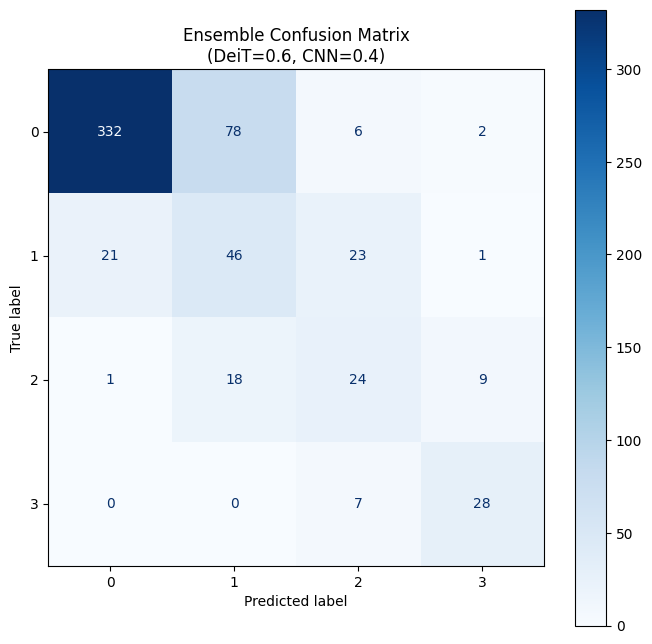

In [5]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
import albumentations as A
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# ---------------------- Configuration ----------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 4 # Classes: 0, 1, 2, 3

# Weights for Ensemble (Adjust these if one model is much better than the other)
WEIGHT_DEIT = 0.6
WEIGHT_CNN  = 0.4

# Paths
TEST_PATH = r"Cropped_ROIs_V0.47_Split\test_by_class"
PATH_DEIT_WEIGHTS = r"D:\Submitted Matrial (conference&journal)\Sagittal Data Artical\V0.47 Dataset analysis\dataspitting\Cropped_ROIs_V0.47_Split\train_by_class\deit_balanced.pth"
PATH_CNN_WEIGHTS  = r"best_model_balanced.pth"

# Image Sizes
IMG_SIZE_DEIT = 224
IMG_SIZE_CNN  = 64

print(f"Running Ensemble on: {DEVICE}")

# ==================================================================================
#                                 1. DEFINE MODELS
# ==================================================================================

# --- Model A: DeiT ---
def get_deit_model():
    model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=False)
    model.head = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(192, NUM_CLASSES)
    )
    return model

# --- Model B: Custom CNN ---
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Architecture must match your saved CNN exactly
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )
        
        # Calculate flatten size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, IMG_SIZE_CNN, IMG_SIZE_CNN)
            out = self.features(dummy)
            flatten_size = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flatten_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ==================================================================================
#                                2. LOAD MODELS
# ==================================================================================

print("\nLoading DeiT Model...")
model_deit = get_deit_model().to(DEVICE)
# Load Weights (Handling potential key mismatches if saved differently)
state_dict = torch.load(PATH_DEIT_WEIGHTS, map_location=DEVICE)
if 'model' in state_dict: state_dict = state_dict['model'] # Handle fastai save format
model_deit.load_state_dict(state_dict, strict=False)
model_deit.eval()

print("Loading CNN Model...")
model_cnn = FlexibleCNN(num_classes=NUM_CLASSES).to(DEVICE)
model_cnn.load_state_dict(torch.load(PATH_CNN_WEIGHTS, map_location=DEVICE))
model_cnn.eval()

# ==================================================================================
#                             3. PREPROCESSING
# ==================================================================================

# Preprocessing for DeiT (224x224, 3 Channels, Normalized)
def preprocess_deit(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.equalizeHist(cv2.resize(img, (IMG_SIZE_DEIT, IMG_SIZE_DEIT)))
    img = np.stack([img]*3, axis=-1) # DeiT expects 3 channels
    
    # Transform
    transform = A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])
    img_tensor = transform(image=img)['image'].unsqueeze(0)
    return img_tensor.to(DEVICE)

# Preprocessing for CNN (64x64, 1 Channel, Normalized)
def preprocess_cnn(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.equalizeHist(cv2.resize(img, (IMG_SIZE_CNN, IMG_SIZE_CNN)))
    
    # Transform
    transform = A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])
    img_tensor = transform(image=img)['image'].unsqueeze(0)
    return img_tensor.to(DEVICE)

# ==================================================================================
#                                4. INFERENCE LOOP
# ==================================================================================

y_true = []
y_pred = []

print("\nStarting Ensemble Inference...")

# Verify folders 0, 1, 2, 3 exist
classes = sorted([d for d in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, d))])
print(f"Classes found: {classes}")

for label_str in classes:
    label_dir = os.path.join(TEST_PATH, label_str)
    true_label = int(label_str)
    
    print(f"Processing Class {true_label}...")
    
    for fname in os.listdir(label_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')): continue
        
        img_path = os.path.join(label_dir, fname)
        
        # 1. Prepare Inputs
        input_deit = preprocess_deit(img_path)
        input_cnn  = preprocess_cnn(img_path)
        
        if input_deit is None or input_cnn is None: continue

        # 2. Get Predictions
        with torch.no_grad():
            # DeiT Output
            out_deit = model_deit(input_deit)
            prob_deit = F.softmax(out_deit, dim=1) # Shape: [1, 4]
            
            # CNN Output
            out_cnn = model_cnn(input_cnn)
            prob_cnn = F.softmax(out_cnn, dim=1)   # Shape: [1, 4]

        # 3. Ensemble (Weighted Average)
        # We average the Probabilities, NOT the raw logits
        final_prob = (WEIGHT_DEIT * prob_deit) + (WEIGHT_CNN * prob_cnn)
        
        # Get final class
        pred_label = torch.argmax(final_prob, dim=1).item()
        
        y_true.append(true_label)
        y_pred.append(pred_label)

# ==================================================================================
#                                5. EVALUATION
# ==================================================================================

print("\n" + "="*30)
print("     ENSEMBLE RESULTS")
print("="*30)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Total Accuracy: {acc:.4f}")

# Classification Report
print("\nClassification Report:")
# target_names must match your class folders (e.g., '0', '1', '2', '3')
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title(f"Ensemble Confusion Matrix\n(DeiT={WEIGHT_DEIT}, CNN={WEIGHT_CNN})")
plt.show()